# Coarse Graining Alanine Dipeptide: Force Matching via CGnet

In this tutorial, we use CGnet [1] to perform a force-matching analysis of alanine dipeptide in order to produce a coarse-grained force field. The alanine dipeptide dataset is truncated and the tutorial does not represent a state of the art analysis; rather, it is designed to avoid time-consuming calculations and is an illustration of the basic pipeline.

## Setting up and loading data

First, we import all the necessary packages. Make sure that you've installed cgnet and all of its dependencies.

In [1]:
import numpy as np
import torch.nn as nn
import torch

from cgnet.feature import (ProteinBackboneFeature, ProteinBackboneStatistics,
                           MoleculeDataset, compute_KLdivergence, compare_distributions)
from cgnet.network import (CGnet, LinearLayer, HarmonicLayer, ForceLoss, ZscoreLayer,
                           lipschitz_projection, dataset_loss, Simulation)

import mdtraj as md
from cgnet.molecule import CGMolecule

from torch.utils.data import DataLoader, RandomSampler
from torch.optim.lr_scheduler import MultiStepLR

import matplotlib.pyplot as plt
%matplotlib inline

Now we load our example dataset. The 10,000 data points are spaced at 10 picosecond intervals for a total of 100 nanoseconds of simulation time (compare with the CGnet paper [1], in which the same system is analyzed with a 1 microsecond trajectory at 1 picosecond intervals).

In [2]:
coords = np.load('./data/ala2_coordinates.npy')
forces = np.load('./data/ala2_forces.npy')

Each of the 10,000 data points has the three-dimensional coordinates and forces of each of the five coarse-grained beads (the five backbone atoms). We verify that the dimensions of the coordinates and forces are (number of frames, number of beads, number of dimensions) by printing their shapes.

Given correctly-shaped coordinates and cooresponding forces, we can make a `MoleculeDataset` that will interface with our network.

In [3]:
print("Coordinates size: {}".format(coords.shape))
print("Force: {}".format(forces.shape))

ala_data = MoleculeDataset(coords,forces)
print("Dataset length: {}".format(len(ala_data)))

Coordinates size: (10000, 5, 3)
Force: (10000, 5, 3)
Dataset length: 10000


## Gathering statistics

The harmonic contributions to the free energy from bonds and angles provide an important regularizing prior form on the energy learned by CGnet. Thus, we need to gather some statistics about our data's features. Specifically, we need the `get_bond_constants` method in the `ProteinBackboneStatistics` class.

In [4]:
stats = ProteinBackboneStatistics(coords)
stats_dict = stats.get_bond_constants()

If we look at the dictionary, we see that the means, standard deviations, and harmonic constants of the two-, three-, and four-body bonds (adjacent distances), angles, and dihedrals, respectively, are stored according to a tuple of the indices of the involves atoms. Dihedrals don't have harmonic constants.

In [5]:
print("Key {}: {}".format((0,1), stats_dict[(0,1)]))
print("Key {}: {}".format((2,3,4), stats_dict[(2,3,4)]))
print("Key {}: {}".format((0,1,2,3,"sin"), stats_dict[(0,1,2,3,"sin")]))
print("There are {} total features.".format(len(stats_dict)))

Key (0, 1): {'mean': tensor(1.3293), 'std': tensor(0.0253), 'k': 933.4679032124934}
Key (2, 3, 4): {'mean': tensor(1.0990), 'std': tensor(0.0509), 'k': 229.97923278808594}
Key (0, 1, 2, 3, 'sin'): {'mean': tensor(-0.7985), 'std': tensor(0.3113)}
There are 17 total features.


We can make separate dictionaries for bonds and angles, respectively:

In [6]:
bonds = {k : stats_dict[k]
         for k in [(i, i+1) for i in range(coords.shape[1]-1)]}
angles = {k : stats_dict[k]
          for k in [(i, i+1, i+2) for i in range(coords.shape[1]-2)]}
print("We have {} backbone beads, {} bonds, and {} angles.".format(
                        coords.shape[1], len(bonds), len(angles)))

We have 5 backbone beads, 4 bonds, and 3 angles.


In addition to the harmonic constants for the bonds and angles, we want the zscores for every feature, including the dihedrals and the non-bond (i.e., non-adjacent) pairwise distances. The `get_zscores` method produces a row of the means and a row of the standard deviations for every feature.

In [7]:
zscores = stats.get_zscores(as_dict=False).float()
print("We have {} statistics for {} features.".format(zscores.shape[0], zscores.shape[1]))

We have 2 statistics for 17 features.


This is equivalent to the following calculation:

In [8]:
order = ['Distances', 'Angles', 'Dihedral_cosines', 'Dihedral_sines']
means = []
stdevs = []
for category in order:
    features = stats.descriptions[category]
    for feature in features:
        if category == 'Dihedral_cosines':
            feature = tuple(list(feature) + ['cos'])
        elif category == 'Dihedral_sines':
            feature = tuple(list(feature) + ['sin'])
        means.append(stats_dict[feature]['mean'])
        stdevs.append(stats_dict[feature]['std'])
zscores_check = np.vstack([means, stdevs])
np.testing.assert_array_equal(zscores, zscores_check)

## Setting up our network architecture

Now we are ready to start designing the architecture of our CGnet. We follow the optimal architecture in the CGnet paper [1], which consists of:

- a feature layer that outputs pairwise distances, angles, and dihedral angles from the Cartesian input trajectory that subtracts the means and divides by the standard deviations,
- 5 hidden linear layers (bias term inclusive) with 160 nodes each, with the first three followed by `Tanh()` activation, and
- harmonic prior layers that compute prior energies from bonds and angles.

The layers are stored in the list `layers` and the priors are stored in the list `priors`.

<img src="./CGnet.png" width=600px>

In [9]:
# Start by scaling according to mean and standard deviation
layers = [ZscoreLayer(zscores)]

# The first hidden layer goes from number of features to 160
num_feat = len(stats_dict)
layers += LinearLayer(num_feat, 160, activation=nn.Tanh())

# The inner hidden layers stay the same size
for _ in range(5):
    layers += LinearLayer(160, 160, activation=nn.Tanh())

# The last layer produces a single value
layers += LinearLayer(160, 1, activation=None)

# Construct prior energy layers
priors  = [HarmonicLayer(bonds,stats.descriptions,"Distances")]
priors += [HarmonicLayer(angles,stats.descriptions, "Angles")]

With our architecture, we are ready to build our CGnet. Because we are recovering the coarse grain potential by matching the potential of mean force (PMF) from the all-atom + solvent model of alanine dipeptide, we imbue our network with the `ForceLoss()` criterion. We can look at our network by printing the object.

In [10]:
ala2_net = CGnet(layers, ForceLoss(),
                 feature=ProteinBackboneFeature(),
                 priors=priors)
print(ala2_net)

CGnet(
  (arch): Sequential(
    (0): ZscoreLayer()
    (1): Linear(in_features=17, out_features=160, bias=True)
    (2): Tanh()
    (3): Linear(in_features=160, out_features=160, bias=True)
    (4): Tanh()
    (5): Linear(in_features=160, out_features=160, bias=True)
    (6): Tanh()
    (7): Linear(in_features=160, out_features=160, bias=True)
    (8): Tanh()
    (9): Linear(in_features=160, out_features=160, bias=True)
    (10): Tanh()
    (11): Linear(in_features=160, out_features=160, bias=True)
    (12): Tanh()
    (13): Linear(in_features=160, out_features=1, bias=True)
  )
  (priors): Sequential(
    (0): HarmonicLayer()
    (1): HarmonicLayer()
  )
  (criterion): ForceLoss()
  (feature): ProteinBackboneFeature()
)


## Training routine and hyperparameters

Next, we setup the training routine. Following Jiang et al (2019), we sample randomly from the dataset with a batch size of 512, Adam optimization with an intial learning rate of 0.003, epochal multiplicative learning rate decay with decay constant $\gamma=0.3$, and L2 Lipschitz regularization via spectral normalization ($\lambda=4.0$) of each weight matrix.

In [11]:
# Hyperparameters

batch_size = 512
learning_rate = 0.003
rate_decay = 0.3
lipschitz_strength = 4.0

num_epochs = 5

save_model = True
directory = '.' # to save model

Now we set up our training tools. We will neglect cross-validation for brevity, but this is __not__ acceptable for real analysis. To do cross-validation, a `testloader` would be needed with validation data.

In [12]:
# Training tools

trainloader = DataLoader(ala_data, sampler=RandomSampler(ala_data),
                         batch_size=batch_size)
optimizer = torch.optim.Adam(ala2_net.parameters(),
                             lr=learning_rate)
scheduler = MultiStepLR(optimizer,milestones=[1,2,3,4,5],
                        gamma=rate_decay)
epochal_train_losses = []
epochal_test_losses  = []
verbose = True
batch_freq = 500
epoch_freq = 1

## Train the model!

Now we can train the model.

In [13]:
for epoch in range(1, num_epochs+1):
    scheduler.step()
    test_loss = 0.00
    for num, batch in enumerate(trainloader):
        optimizer.zero_grad()
        coord, force = batch
        energy, pred_force = ala2_net.forward(coord)
        batch_loss = ala2_net.criterion(pred_force, force)
        batch_loss.backward()
        optimizer.step()
        
        # perform L2 lipschitz check and projection
        lipschitz_projection(ala2_net, strength=lipschitz_strength)
        if verbose:
            if (num+1) % batch_freq == 0:
                print(
                    "Batch: {}\tTrain: {}\tTest: {}".format(
                        num+1, batch_loss, test_loss)
                )
    train_loss = dataset_loss(ala2_net, trainloader)
    #test_loss = dataset_loss(ala2_net, self.testloader).data
    if verbose:
        if epoch % epoch_freq == 0:
            print(
                "Epoch: {}\tTrain: {}\tTest: {}".format(
    epoch, train_loss, test_loss))
        epochal_train_losses.append(train_loss)
        #epochal_test_losses.append(test_loss)
        
if save_model:
    torch.save(ala2_net,"{}/ala2_net.pt".format(directory))

Epoch: 1	Train: 385.3000183105469	Test: 0.0
Epoch: 2	Train: 383.6142883300781	Test: 0.0
Epoch: 3	Train: 383.26318359375	Test: 0.0
Epoch: 4	Train: 383.14337158203125	Test: 0.0
Epoch: 5	Train: 383.1103515625	Test: 0.0


We can plot at the training loss over the epochs.

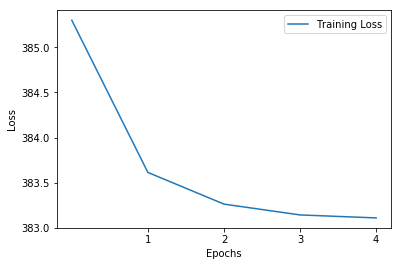

In [14]:

fig = plt.figure()
plt.plot(np.arange(0,len(epochal_train_losses),1),
         epochal_train_losses, label='Training Loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.xticks(np.arange(1,5))
plt.ylabel("Loss")
plt.show()

## Using the coarse-grained force field to simulate system dynamics

First we set up initial coordinates which will be used as the starting points for independent simulations.

We will run 1000 independent simulations seeded evenly the original dataset for 1000 timesteps each. These paramters can be changed below.

In [15]:
n_sims = 100
n_timesteps = 10000
save_interval = 10

In [16]:
initial_coords = np.concatenate([coords[i].reshape(-1,5,3)
                                 for i in np.arange(0, 10000, 10000//n_sims)],
                                 axis=0)
initial_coords = torch.tensor(initial_coords, requires_grad=True)
print("Produced {} initial coordinates.".format(len(initial_coords)))

sim = Simulation(ala2_net, initial_coords, length=n_timesteps,
                 save_interval=save_interval, beta=stats.beta,
                 verbose=True, save_potential=True)

traj = sim.simulate()

Produced 100 initial coordinates.
Generating 100 simulations of length 10000 at 10-step intervals
10% finished
20% finished
30% finished
40% finished
50% finished
60% finished
70% finished
80% finished
90% finished
100% finished.


## Analyze the simulation output

Now we want to see what our simulated coarse-grained dynamics are like. First we create an `mdtraj`-friendly [2] `CGMolecule` object.

In [17]:
names = ['C', 'N', 'CA', 'C', 'N']
resseq = [1, 2, 2, 2, 3]
resmap = {1: 'ACE', 2: 'ALA', 3: 'NME'}

ala2_cg = CGMolecule(names=names, resseq=resseq, resmap=resmap,
                          bonds='standard')

We can input our training and simulated coordinates in order to make `mdtraj` trajectories out of our data.

In [18]:
ala2_traj = ala2_cg.make_trajectory(coords)
ala2_simulated_traj = ala2_cg.make_trajectory(np.concatenate(traj, axis=0))

Using `mdtraj`, we compute the backbone $\phi$ and $\psi$ torsional angles of our reference and simulated systems.

In [19]:
_, phi = md.compute_phi(ala2_traj)
_, psi = md.compute_psi(ala2_traj)

_, sim_phi = md.compute_phi(ala2_simulated_traj)
_, sim_psi = md.compute_psi(ala2_simulated_traj)

For the reference coordinates, we compute the potential using our network. For the simulated coordinates, we saved the potential when we ran the simulation.

In [20]:
pot, _ = ala2_net.forward(torch.tensor(coords, requires_grad=True))
pot = pot.detach().numpy()
pot = pot - np.min(pot)

sim_pot = np.concatenate(sim.simulated_potential, axis=0)
sim_pot = sim_pot - np.min(sim_pot)

Finally, we plot the reference and simulation Ramachandran plots. Since we didn't train for very long, and because we used only a small amount of data, this shouldn't be too impressive.

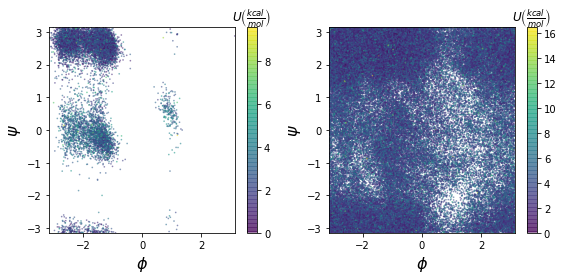

In [21]:
plt.subplots(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(phi.reshape(-1), psi.reshape(-1),
            c=pot.flatten(),
            cmap=plt.get_cmap("viridis"),alpha=0.5,s=0.5)
plt.xlabel(r'$\phi$',fontsize=16)
plt.ylabel(r'$\psi$',fontsize=16)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.title(r'Original all-atom trajectory')
clb=plt.colorbar()
clb.ax.set_title(r'$U\left(\frac{kcal}{mol}\right)$')

plt.subplot(1,2,2)
plt.scatter(sim_phi.reshape(-1), sim_psi.reshape(-1),
            c=sim_pot.flatten(),
            cmap=plt.get_cmap("viridis"),alpha=0.5,s=0.5)
plt.xlabel(r'$\phi$',fontsize=16)
plt.ylabel(r'$\psi$',fontsize=16)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.title('Simulated CG trajectory')
clb=plt.colorbar()
clb.ax.set_title(r'$U\left(\frac{kcal}{mol}\right)$')

plt.tight_layout()

We can also view the simulated free energy $F = U - TS$. To do this, we histogram the 2-dimensional dihedral trajectory and convert counts to populations $\pi_i$ for each bin $i$. Then, we transform the nonzero populations into energies according to $F_i = \beta^{-1}\log\pi_i$.

First we set up a graphing utility for our Ramachandran plots.

In [22]:
def plot_ramachandran(phi, psi, bins=60, cmap=plt.cm.magma):
    edges = np.array([[-np.pi, np.pi], [-np.pi, np.pi]])
    counts, _, _ = np.histogram2d(psi.reshape(-1),
                                  phi.reshape(-1),
                                  bins=bins,
                                  range=edges)
    populations = counts / np.sum(counts)
    
    # compute energies for only non-zero entries
    # 1/beta is approximately 0.6 kcal/mol at 300 K
    energies = -0.6*np.log(populations,
                           out=np.zeros_like(populations),
                           where=(populations > 0))
    
    # make the lowest energy slightly above zero
    energies = np.where(energies,
                        energies-np.min(energies[np.nonzero(energies)]) + 1e-6,
                        0)
    
    # mask the zero values from the colormap
    zvals_masked = np.ma.masked_where(energies == 0, energies)

    cmap.set_bad(color='white')
    img = plt.imshow(zvals_masked, interpolation='nearest', cmap = cmap)
    plt.gca().invert_yaxis()
    
    plt.xticks([-0.5, bins/2, bins], 
               [r'$-\pi$', r'$0$', r'$\pi$'])

    plt.yticks([-0.5, bins/2, bins],
               [r'$-\pi$', r'$0$', r'$\pi$'])
    
    plt.xlabel(r'$\phi$',fontsize=16)
    plt.ylabel(r'$\psi$',fontsize=16)
    
    cb=plt.colorbar()
    cb.ax.set_title(r'$\tilde{F}\left(\frac{kcal}{mol}\right)$')

Now we plot the free energies for the original and CG trajectories. Again, we expect this to look bad because we used only 1% of the dataset.

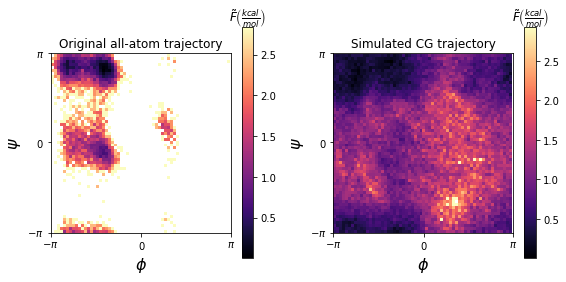

In [23]:
fig, axes = plt.subplots(figsize=(8,4))

plt.subplot(1,2,1)
plot_ramachandran(phi, psi)
plt.title('Original all-atom trajectory')

plt.subplot(1,2,2)
plot_ramachandran(sim_phi, sim_psi)
plt.title('Simulated CG trajectory')

plt.tight_layout()

Nice. We can also inspect how the distributions of features from the CG simulation compare to that of the original simulation.

In [24]:
bond_idx = [[i,i+1] for i in range(len(bonds))]
ang_idx = [[i,i+1,i+2] for i in range(len(angles))]

bond_traj = md.compute_distances(ala2_traj, bond_idx)
ang_traj = md.compute_angles(ala2_traj, ang_idx)
sim_bond_traj = md.compute_distances(ala2_simulated_traj, bond_idx)
sim_ang_traj = md.compute_angles(ala2_simulated_traj, ang_idx)
print(bond_traj.shape)

(10000, 4)


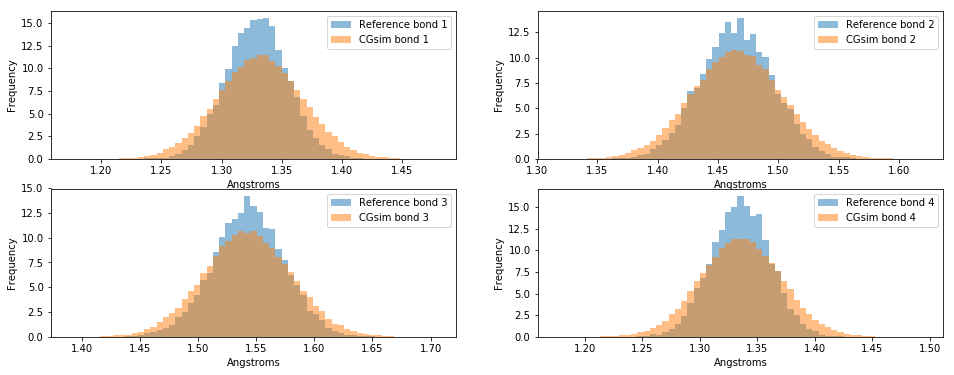

In [25]:
divs=[]
fig = plt.figure(figsize=(16,6))
for i in range(bond_traj.shape[1]):
    plt.subplot(int(len(bonds)/2),2, i+1)
    div = compare_distributions(bond_traj[:,i],sim_bond_traj[:,i],
                                nbins=60,
                                labels=['Reference bond {}'.format(i+1),'CGsim bond {}'.format(i+1)],
                                xaxis='Angstroms', yaxis='Frequency',
                                kl_div= True)
    divs.append(div)
    plt.title = "Bond {}".format(i+1)    
plt.show()

As a measure distributional overlap, we compute the discrete Kullback-Leibler (KL) divergence as follows:


\begin{equation}
    D_{KL} (\mathcal{B}_{CG} || \mathcal{B}_{ref}) = \sum_{bin}^{nbins} \mathcal{B}_{CG}(bin) \log{\frac{\mathcal{B}_{CG}(bin)}{\mathcal{B}_{ref}(bin)}}
\end{equation}

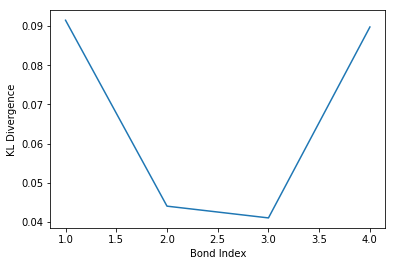

In [26]:
plt.plot(np.arange(1,len(divs)+1,1), divs)
plt.xlabel('Bond Index')
plt.ylabel('KL Divergence')
plt.show()

We see that, in accordance with plots above, the CG simulation can reproduce all of the bond distributions well, especially the two internal bonds. We can perform the same analyses for angles, dihedrals, and non-bonded pairs as well.

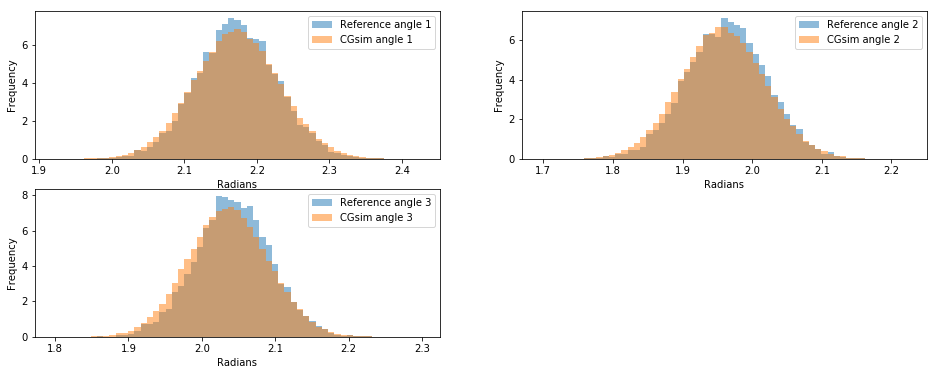

In [27]:
divs=[]
fig = plt.figure(figsize=(16,6))
for i in range(ang_traj.shape[1]):
    plt.subplot(round(len(angles)/2),2, i+1)
    div = compare_distributions(ang_traj[:,i],sim_ang_traj[:,i],
                                nbins=60,
                                labels=['Reference angle {}'.format(i+1),'CGsim angle {}'.format(i+1)],
                                xaxis='Radians', yaxis='Frequency',
                                kl_div= True)
    divs.append(div)
    plt.title = "Angle {}".format(i+1)    
plt.show()

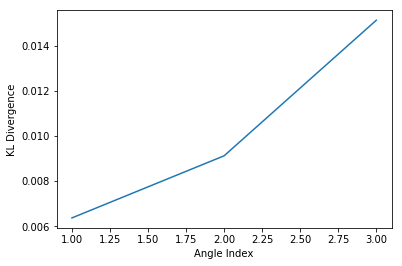

In [28]:
plt.plot(np.arange(1,len(divs)+1,1), divs)
plt.xlabel('Angle Index')
plt.ylabel('KL Divergence')
plt.show()

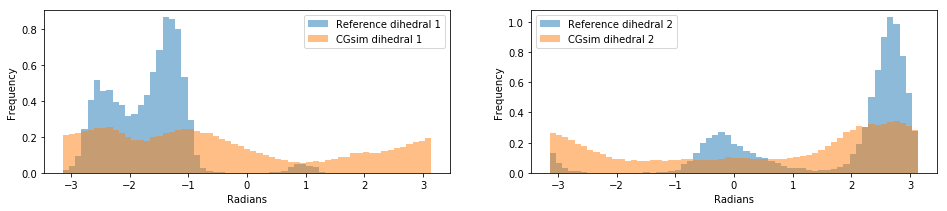

In [29]:
dihedrals = np.hstack((phi,psi))
sim_dihedrals = np.hstack((sim_phi,sim_psi))
divs = []
fig = plt.figure(figsize=(16,3))
for i in range(dihedrals.shape[1]):
    plt.subplot(1,2, i+1)
    div = compare_distributions(dihedrals[:,i],sim_dihedrals[:,i],
                                nbins=60,
                                labels=['Reference dihedral {}'.format(i+1),'CGsim dihedral {}'.format(i+1)],
                                xaxis='Radians', yaxis='Frequency',
                                kl_div= True)
    divs.append(div)
    plt.title = "Bond {}".format(i+1)    
plt.show()

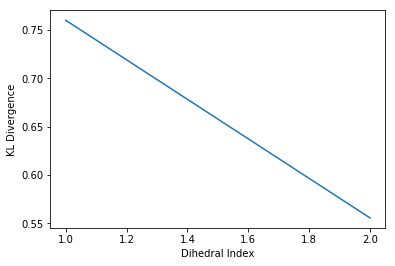

In [30]:
plt.plot(np.arange(1,len(divs)+1,1), divs)
plt.xlabel('Dihedral Index')
plt.ylabel('KL Divergence')
plt.show()

In [31]:
dist_idx = [[0,2],[0,3],[0,4],[1,3],[1,4],[2,4]]
dist_traj = md.compute_distances(ala2_traj, dist_idx)
sim_dist_traj = md.compute_distances(ala2_simulated_traj, dist_idx)

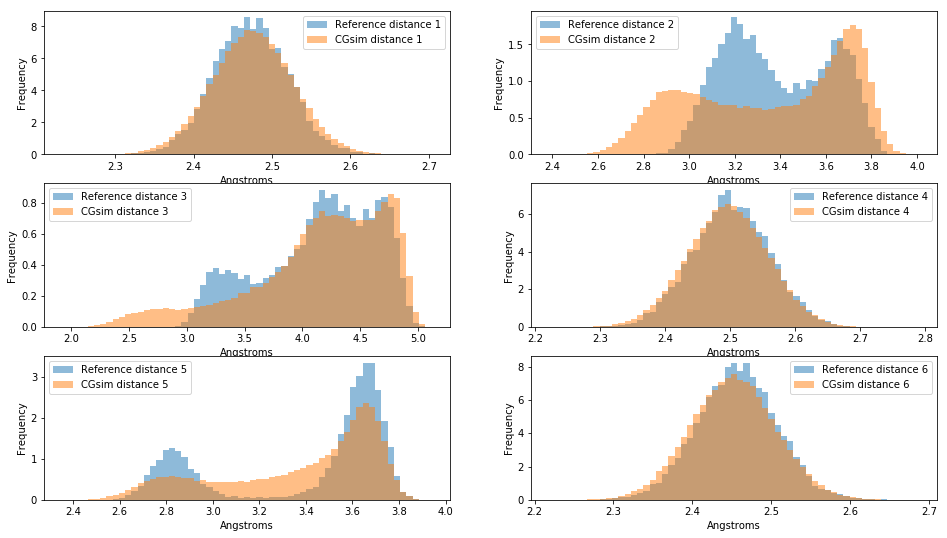

In [32]:
divs = []
fig = plt.figure(figsize=(16,9))
for i in range(dist_traj.shape[1]):
    plt.subplot(round(len(dist_idx)/2),2, i+1)
    div = compare_distributions(dist_traj[:,i],sim_dist_traj[:,i],
                                nbins=60,
                                labels=['Reference distance {}'.format(i+1),'CGsim distance {}'.format(i+1)],
                                xaxis='Angstroms', yaxis='Frequency',
                                kl_div= True)
    divs.append(div)
    plt.title = "Distance {}".format(i+1)    
plt.show()

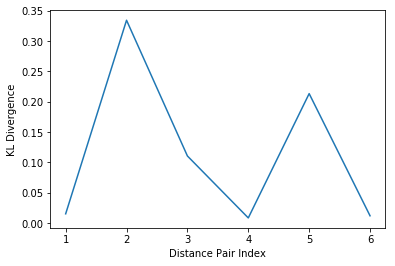

In [33]:
plt.plot(np.arange(1,len(divs)+1,1), divs)
plt.xlabel('Distance Pair Index')
plt.ylabel('KL Divergence')
plt.show()

#### *References*

[1] Wang, J., Olsson, S., Wehmeyer, C., Pérez, A., Charron, N. E., de Fabritiis, G., Noé, F., and Clementi, C. (2019). Machine Learning of Coarse-Grained Molecular Dynamics Force Fields. _ACS Central Science._ https://doi.org/10.1021/acscentsci.8b00913

[2] McGibbon, R. T., Beauchamp, K. A., Harrigan, M. P., Klein, C., Swails, J. M., Hernández, C. X., Schwantes, C. R., Wang, L.-P., Lane, T. J., and Pande, V. S. (2015). MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. _Biophys J._ http://dx.doi.org/10.1016/j.bpj.2015.08.015